In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from copy import deepcopy

from alea import BlueiceExtendedModel, Runner
import inference_interface as ii
import scipy.stats as sps
from fogtask.fogtask import *
from scipy.interpolate import interp1d
from copy import deepcopy

/Users/kdund/Software/xenon_software/wimprates/wimprates/__init__.py:6: UserWarning: Default WIMP parameters are changed in accordance with https://arxiv.org/abs/2105.00599 (github.com/JelleAalbers/wimprates/pull/14)
  warnings.warn(


## Initialise simplified model
cs1cs2 only, 
WIMP mass 10-250 GeV
notional rates

In [3]:
model = BlueiceExtendedModel.from_config("../likelihoods/xlzd_wimp_search_contour_v0.51.yaml")
model_expectation = BlueiceExtendedModel.from_config("../likelihoods/xlzd_wimp_search_nonnormalised_v0.51.yaml")

building data generators: 100%|█████████████████████| 1/1 [00:00<00:00, 84.25it/s]


In [6]:
for k,m in sorted(model_expectation.get_expectation_values(wimp_mass=50).items()):
    print("{:s}\t{:.3f}".format(k,m))

CEvNS_other	0.046
Kr85	13.992
Pb214	3.403
SolarER	24.348
WIMP	248.929
Xe124	5.290
Xe136	10.809
neutron	0.005


In [7]:
for k,m in sorted(model.get_expectation_values(wimp_mass=50).items()):
    print("{:s}\t{:.3f}".format(k,m))

CEvNS_other	0.046
Kr85	13.992
Pb214	3.403
SolarER	24.348
WIMP	1.000
Xe124	5.290
Xe136	10.809
neutron	0.005


### Settings

Livetimes to run

target mass, xsec gives the true WIMP signal that will be injected

In [8]:
livetimes = [3,10,30,100,300,1000]
#livetimes = [3]

n_toys = 100

sensi_livetimes = livetimes[0:4]

target_mass = 20
target_xsec = 4e-49
target_mu_per_ty = float(model_expectation.get_expectation_values(wimp_mass = target_mass, WIMP_rate_multiplier = target_xsec/1e-45)["WIMP"])

wimp_masses = np.geomspace(9.,250.,51)
rates = np.linspace(0.,40.,201)
WMs, Rs = np.meshgrid(wimp_masses, rates)

mu_per_wimp_mass = np.array([model_expectation.get_expectation_values(wimp_mass = wm)["WIMP"] for wm in wimp_masses])
mu_per_wimp_mass = interp1d(wimp_masses, mu_per_wimp_mass, bounds_error=False, fill_value=0.)

### Sensitivity computation

Just very simple, all asymptotic

In [9]:
try:
    LL0ss = np.load("cached_sensitivity.npz.npy", allow_pickle=True)[()]
    print("loaded sensi from cache")
    n_toys = 100
    LLs = np.zeros(WMs.shape)
    rates = np.linspace(0.,max(4*target_mu_per_ty, 50/livetime),len(rates))
    WMs, Rs = np.meshgrid(wimp_masses, rates)
except:
    LL0ss = dict()
    n_toys = 100
    for livetime in sensi_livetimes: 
        LL0s = []
        for n in tqdm(range(n_toys)):
            dataset = model.generate_data(livetime=livetime, WIMP_rate_multiplier = 0. , wimp_mass = target_mass)
            fixed_args = structured_array_to_dict(dataset["generate_values"])
            fixed_args.pop("WIMP_rate_multiplier")
            fixed_args.pop("wimp_mass")
            model.data = dataset
    
            best_fit = model.fit(**fixed_args)
            #best_fits[livetime] = best_fit
    
            LLs = np.zeros(WMs.shape)
            rates = np.linspace(0.,max(4*target_mu_per_ty, 50/livetime),len(rates))
    
            WMs, Rs = np.meshgrid(wimp_masses, rates)
    
            for i, wimp_mass in enumerate(wimp_masses): 
                for j, WIMP_rate_multiplier in enumerate(rates):
                    #_, LLs[i,j] = model.fit(WIMP_rate_multiplier = WIMP_rate_multiplier, wimp_mass = wimp_mass, **fixed_args)
                    LLs[j,i] = -2*model.ll(WIMP_rate_multiplier = WIMP_rate_multiplier, wimp_mass = wimp_mass, **fixed_args)
                j_min = np.argmin(LLs[:,i])
                LLs[:,i] -= LLs[j_min,i]
                LLs[0:j_min,i] = 0.
            LL0s.append(LLs)
        LL0ss[livetime] = LL0s
    
    np.save("cached_sensitivity.npz", LL0ss)

 74%|████████████████████████████████▌           | 74/100 [02:02<00:42,  1.65s/it]

E VariableMetricBuilder Initial matrix not pos.def.


100%|███████████████████████████████████████████| 100/100 [04:59<00:00,  3.00s/it]


In [46]:
LLss = dict()
Rss = dict()
best_fits = dict()
null_fits = dict()


previous_dataset = None
for livetime in livetimes: 
    dataset = model.generate_data(livetime=livetime, WIMP_rate_multiplier = target_mu_per_ty, wimp_mass = target_mass)
    if previous_dataset is not None: 
        dataset["sr0"][0:len(previous_dataset)] = previous_dataset
        previous_dataset = dataset["sr0"]
    fixed_args = structured_array_to_dict(dataset["generate_values"])
    fixed_args.pop("WIMP_rate_multiplier")
    fixed_args.pop("wimp_mass")
    model.data = dataset

    best_fit = model.fit(**fixed_args)
    best_fits[livetime] = best_fit
    null_fit = model.fit(WIMP_rate_multiplier=0, **fixed_args)
    null_fits[livetime] = null_fit
    ll_best = best_fit[1]

    LLs = np.zeros(WMs.shape)
    rates = np.linspace(0.,max(4*target_mu_per_ty, 50/livetime),len(rates))

    WMs, Rs = np.meshgrid(wimp_masses, rates)

    for i, wimp_mass in enumerate(tqdm(wimp_masses)): 
        for j, WIMP_rate_multiplier in enumerate(rates):
            #_, LLs[i,j] = model.fit(WIMP_rate_multiplier = WIMP_rate_multiplier, wimp_mass = wimp_mass, **fixed_args)
            LLs[j,i] = model.ll(WIMP_rate_multiplier = WIMP_rate_multiplier, wimp_mass = wimp_mass, **fixed_args)
    LLss[livetime] = 2*(ll_best-LLs)
    Rss[livetime] = Rs
dataset_number = np.random.randint(0,1000000)

100%|█████████████████████████████████████████████| 51/51 [00:14<00:00,  3.63it/s]


In [47]:
plt.clf()
sensitivities = dict()
livetime = 3
for livetime in sensi_livetimes:
    LL0s = LL0ss[livetime]
    ULs = np.zeros((len(wimp_masses), n_toys))
    for i in range(n_toys):
        LL0 = LL0s[i]
        levels = [sps.chi2(1).isf(0.1)]
        contours = plt.contour(WMs, 1e-45*Rss[livetime]/(mu_per_wimp_mass(WMs)), LL0, levels=levels, colors = "k", alpha=0.3)
        #plt.yscale("log")
        #plt.xscale("log")
        line = contours.allsegs[0][0]
        ULs[:,i] = interp1d(line[:,0], line[:,1], bounds_error=False, fill_value=0.)(wimp_masses)
    
    plt.plot(wimp_masses, np.median(ULs,axis=1), color="magenta")
    sensitivities[livetime] = np.median(ULs,axis=1)
    plt.yscale("log")
    plt.xscale("log")
    plt.ylim(1e-48,1e-46)
    plt.clf()

<Figure size 640x480 with 0 Axes>

In [48]:
import matplotlib as mpl
import matplotlib.patheffects as pe

norm = mpl.colors.LogNorm(vmin=1.,vmax=1000.)
sm = plt.cm.ScalarMappable(cmap=None, norm=norm)
sm.set_array([3,10,300,1000])

3


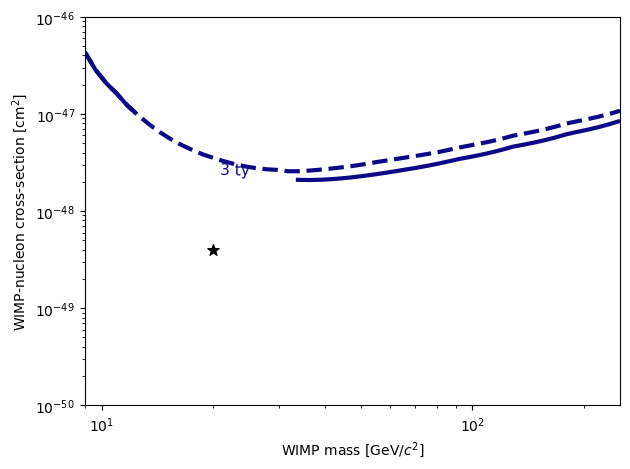

3
10


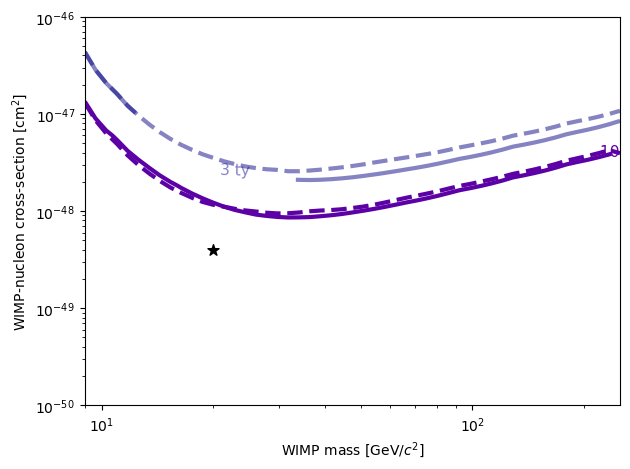

3
10
30


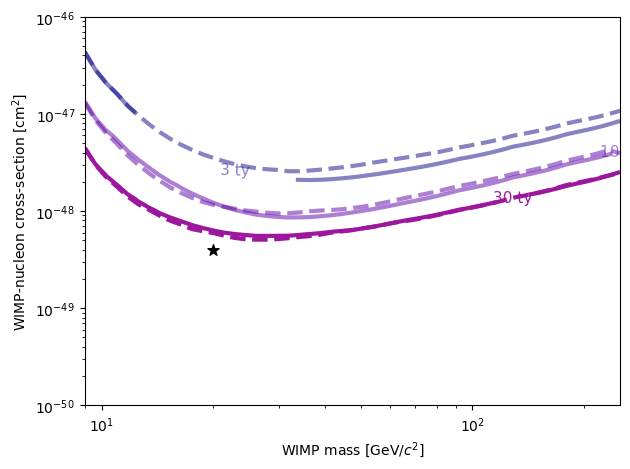

3
10
30


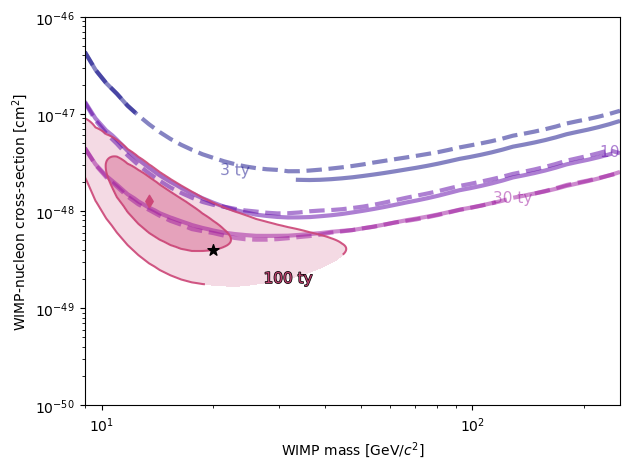

3
10
30


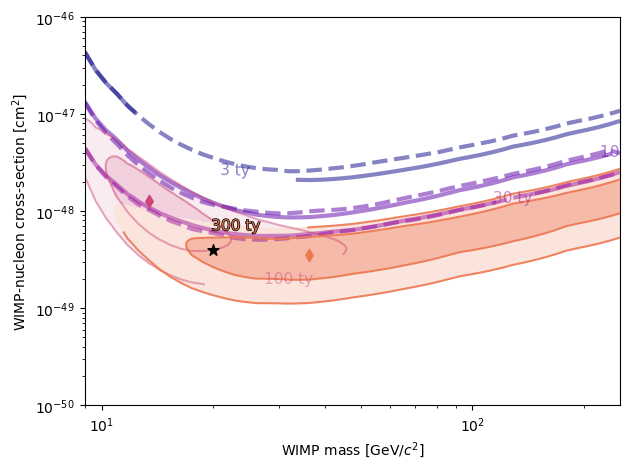

3
10
30


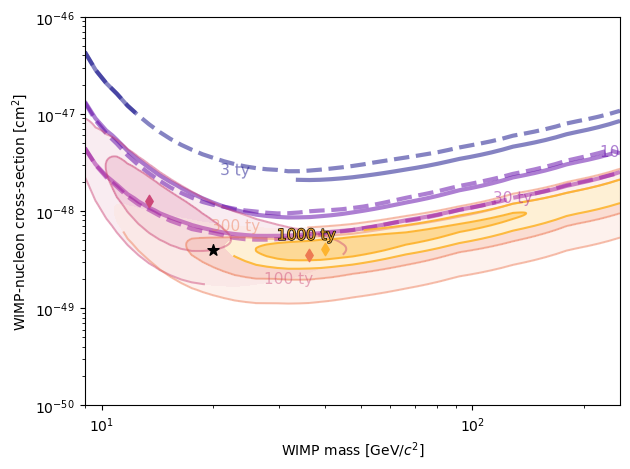

In [49]:
for ilt in range(1,len(livetimes)+1):
    plt.clf()
    
    limit_colors = ["navy","dodgerblue","cyan"]
    contour_colors = ["purple","salmon","crimson","orange"]
    
    cmap = plt.colormaps.get_cmap("plasma")
    colors = [cmap(i/(len(livetimes))) for i in range(len(livetimes))]
    plt.xlim(10,250)
    for il, livetime in enumerate(livetimes[0:ilt]):

        ea = 1.
        if il < ilt-1:
            ea = 0.5
    
    
        llr = 2*(best_fits[livetime][1] - null_fits[livetime][1])
        color = colors[0]
        colors = colors[1::]
        
    
        if 9<llr: 
            L = LLss[livetime]
            L[L<0.] = 0.
            #color = contour_colors[0]
            contour_colors = contour_colors[1::]
            levels = [0., sps.chi2(2).isf(2*sps.norm().sf(2))]
            #levels = [0.,4.01]
            contours = plt.contourf(WMs, 1e-45*Rss[livetime]/(mu_per_wimp_mass(WMs)), LLss[livetime], levels=levels, colors = "white", alpha=1*ea)
            #levels = [1,4]
            levels = [sps.chi2(2).isf(2*sps.norm().sf(1)),sps.chi2(2).isf(2*sps.norm().sf(2))]
            contours = plt.contourf(WMs, 1e-45*Rss[livetime]/(mu_per_wimp_mass(WMs)), LLss[livetime], levels=levels, colors = color, alpha=0.2*ea)
            levels = [sps.chi2(2).isf(2*sps.norm().sf(2))]
            contours = plt.contour(WMs, 1e-45*Rss[livetime]/(mu_per_wimp_mass(WMs)), LLss[livetime], levels=levels, colors = color, alpha=0.9*ea)
            text = plt.clabel(contours, levels, fmt={levels[0]:"{:.0f} ty".format(livetime)},fontsize=11, inline_spacing=2, rightside_up=True, zorder=+1000, use_clabeltext=False)
            if il == ilt-1:
                try:
                    text[0].set_path_effects([pe.withStroke(linewidth=1, foreground="k")])
                except:
                    pass
            levels = [0.,1]
            levels = [0.,sps.chi2(2).isf(2*sps.norm().sf(1))]
            contours = plt.contourf(WMs, 1e-45*Rss[livetime]/(mu_per_wimp_mass(WMs)), LLss[livetime], levels=levels, colors = color, alpha=0.5*ea)
            contours = plt.contour(WMs, 1e-45*Rss[livetime]/(mu_per_wimp_mass(WMs)), LLss[livetime], levels=levels, colors = color, alpha=0.9*ea)
            best_fit = best_fits[livetime]
            plt.scatter([best_fit[0]["wimp_mass"]], [1e-45*best_fit[0]["WIMP_rate_multiplier"]/(mu_per_wimp_mass(best_fit[0]["wimp_mass"]))], color=color, marker="d",s=40,zorder=+400)
            #if il == ilt-1:
            #    lim_max = 1e-45*best_fit[0]["WIMP_rate_multiplier"]/(mu_per_wimp_mass(best_fit[0]["wimp_mass"]))
            #    plt.text(100, lim_max,"{:.0f} tonne-years\n{:.1f}$\\sigma$".format(livetime,np.sqrt(max(llr,0.))), color=color, 
            #            path_effects=[pe.withStroke(linewidth=1, foreground="k")])
        else:
            #color = limit_colors[0]
            limit_colors = limit_colors[1::]
            levels = [sps.chi2(1).isf(0.1)]
            L = deepcopy(LLss[livetime])
            for i, _ in enumerate(wimp_masses):
                i_min = np.argmin(L[:,i])
                L[:,i] -= L[i_min,i]
                L[0:i_min,i] = 0.
            contours = plt.contour(WMs, 1e-45*Rss[livetime]/(mu_per_wimp_mass(WMs)), L, levels=levels, colors = color,linewidths=3, alpha=1.*ea)
            plt.clabel(contours, levels, fmt={levels[0]:"{:.0f} ty".format(livetime)},fontsize=11, inline_spacing=7, rightside_up=False)

            lim_max = contours.allsegs[0][0][-1,1]
            
            
            print(livetime)
            if livetime in sensi_livetimes:
                plt.plot(wimp_masses, sensitivities[livetime], color=color, linestyle="--", linewidth=3, alpha=1.*ea)
                lim_max = sensitivities[livetime][-1]
            #if il == ilt-1:
            #    plt.text(100, lim_max,"{:.0f} tonne-years\n{:.1f}$\\sigma$".format(livetime,np.sqrt(max(llr,0.))), color=color, 
            #            path_effects=[pe.withStroke(linewidth=0.5, foreground="k")])

    
    plt.scatter([target_mass], [target_xsec], color="k", marker="*",s=70,zorder=+500)
    plt.xscale("log")
    plt.yscale("log")
    plt.ylim(1e-50,1e-46)
    plt.xlim(9,250)
    if False:
        cbar = plt.colorbar(sm, ticks=livetimes,label="Exposure [ty]", ax = plt.gca(), alpha=0.)
        colors = [cmap(i/len(livetimes)) for i in range(len(livetimes))]
        cbar.add_lines(levels=livetimes[0:ilt], colors=colors[0:ilt], linewidths=5)
    plt.xlabel("WIMP mass [GeV/$c^2$]")
    plt.ylabel("WIMP-nucleon cross-section [cm$^2$]")
    plt.tight_layout()
    plt.savefig("xlzd_example_discovery_{:d}_until_livetime_{:.0f}.pdf".format(dataset_number, livetimes[ilt-1]))
    plt.savefig("xlzd_example_discovery_{:d}_until_livetime_{:.0f}.png".format(dataset_number, livetimes[ilt-1]))
    plt.show()

In [50]:
command = "convert -delay 100 "
for livetime in livetimes: 
    command += "xlzd_example_discovery_{:d}_until_livetime_{:.0f}.png ".format(dataset_number, livetime)
command += "xlzd_example_discovery_{:d}.gif ".format(dataset_number, livetime)

print(command)


convert -delay 100 xlzd_example_discovery_870930_until_livetime_3.png xlzd_example_discovery_870930_until_livetime_10.png xlzd_example_discovery_870930_until_livetime_30.png xlzd_example_discovery_870930_until_livetime_100.png xlzd_example_discovery_870930_until_livetime_300.png xlzd_example_discovery_870930_until_livetime_1000.png xlzd_example_discovery_870930.gif 


In [ ]:
for ilt in range(1,len(livetimes)+1):
    plt.clf()
    
    limit_colors = ["navy","dodgerblue","cyan"]
    contour_colors = ["purple","salmon","crimson","orange"]
    
    cmap = plt.colormaps.get_cmap("plasma")
    colors = [cmap(i/len(livetimes)) for i in range(len(livetimes))]
    for il, livetime in enumerate(livetimes[0:ilt]):

        ea = 1.
        if il < ilt-1:
            ea = 0.5
    
        llr = 2*(best_fits[livetime][1] - null_fits[livetime][1])
        color = colors[0]
        colors = colors[1::]
    
        if 9<llr: 
            #color = contour_colors[0]
            contour_colors = contour_colors[1::]
            levels = [0., sps.chi2(2).isf(2*sps.norm().sf(2))]
            #levels = [0.,4.01]
            contours = plt.contourf(WMs, Rss[livetime], LLss[livetime], levels=levels, colors = "white", alpha=1*ea)
            #levels = [1,4]
            levels = [sps.chi2(2).isf(2*sps.norm().sf(1)),sps.chi2(2).isf(2*sps.norm().sf(2))]
            contours = plt.contourf(WMs, Rss[livetime], LLss[livetime], levels=levels, colors = color, alpha=0.2*ea)
            contours = plt.contour(WMs, Rss[livetime], LLss[livetime], levels=levels, colors = color, alpha=0.9*ea)
            levels = [-0.01,1]
            levels = [-0.01,sps.chi2(2).isf(2*sps.norm().sf(1))]
            contours = plt.contourf(WMs, Rss[livetime], LLss[livetime], levels=levels, colors = color, alpha=0.5*ea)
            contours = plt.contour(WMs, Rss[livetime], LLss[livetime], levels=levels, colors = color, alpha=0.9*ea)
            best_fit = best_fits[livetime]
            plt.scatter([best_fit[0]["wimp_mass"]], [1e-45*best_fit[0]["WIMP_rate_multiplier"]/(mu_per_wimp_mass(b))], color=color, marker="d",s=40,zorder=+400)
        else:
            #color = limit_colors[0]
            limit_colors = limit_colors[1::]
            levels = [sps.chi2(1).isf(0.1)]
            L = deepcopy(LLss[livetime])
            for i, _ in enumerate(wimp_masses):
                i_min = np.argmin(L[:,i])
                L[:,i] -= L[i_min,i]
                L[0:i_min,i] = 0.
            contours = plt.contour(WMs, Rss[livetime], L, levels=levels, colors = color,linewidths=3, alpha = 1.*ea)
            print(livetime)
            #if livetime in sensi_livetimes:
            #    plt.plot(wimp_masses, sensitivities[livetime], color=color, linestyle="--", linewidth=3)
    
    plt.scatter([target_mass], [target_mu_per_ty], color="k", marker="*",s=70,zorder=+500)
    plt.xscale("log")
    #plt.yscale("log")
    #plt.ylim(1e-50,1e-46)
    plt.ylim(0,2)
    plt.yscale("asinh")
    plt.xlim(9,250)
    plt.xlabel("WIMP mass [GeV/$c^2$]")
    plt.ylabel("Expected Rate [/ty]")
    plt.show()